# Определение перспективного тарифа для телеком-компании

## Описание проекта

Клиентам  компании «Мегалайн» — федерального оператора сотовой связи - предлагаются два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В наличии данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:

Тариф «Смарт»:<br>

    1. Ежемесячная плата: 550 рублей
    2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    3. Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля
        - сообщение: 3 рубля
        - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»:<br>

    1. Ежемесячная плата: 1950 рублей
    2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    3. Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль
        - сообщение: 1 рубль
        - 1 Гб интернет-трафика: 150 рублей
        
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

### Содержание<a class='tocSkip'>
    
[Шаг 1. Изучение файлов с данными](#step1)
    
[Шаг 2. Подготовка данных](#step2)<br>
    
[Шаг 3. Анализ данных](#step3)<br>
    
[Шаг 4. Проверка гипотез](#step4)<br>
    
[Шаг 5. Общий вывод](#step5)<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
from scipy.stats import bootstrap

## Шаг 1. Изучение файлов с данными <a id="step1"></a> 

In [3]:
calls=pd.read_csv('/datasets/calls.csv')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.agg(['min', 'max','nunique'])

,id,call_date,duration,user_id
min,1000_0,2018-01-01,0.0,1000
max,1499_99,2018-12-31,38.0,1499
nunique,202607,365,2871.0,492


### В датафрейме calls собрана информация о звонках пользователей:
1. id - номер звонка конкретного пользователя с конкретным user_id
2. call_date - дата звонка
3. duration - длительность звонка (разговора)
4. user_id - id пользователя

### Выводы по предварительному анализу таблицы:
1. Для того, чтобы в дальнейшем было удобнее работать с датами, тип данных в столбце "call_date" необходимо будет заменить с object на datetime64 
2. В таблице хранится информация по звонкам  за период с 1 января по 31 декабря 2018 года - всего за 365 дней.
3. Минимальная продолжительность разговора - 0, максимальная 38 минут.
4. Всего в таблице данные по 492 пользователям, номера которых с 1000 по 1499 - видимо, идут не строго по порядку.

In [5]:
internet=pd.read_csv('/datasets/internet.csv')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.agg(['min', 'max','nunique'])

,Unnamed: 0,id,mb_used,session_date,user_id
min,0,1000_0,0.00,2018-01-01,1000
max,149395,1499_99,1724.83,2018-12-31,1499
nunique,149396,149396,70003.00,365,497


### В датафрейме internet собрана информация об использовании интернет-трафика пользователями:
1. Unnamed - номера строк по порядку с 0 до 149395
2. id - номер выхода конкретного пользователя с конкретным user_id в интернет
3. mb_used - количество использованных МБайт
4. session_date - дата выхода в интернет
5. user_id - id пользователя

### Выводы по предварительному анализу таблицы:
1. Для того, чтобы в дальнейшем было удобнее работать с датами, тип данных в столбце "session_date" необходимо будет заменить с object на datetime64 
2. В таблице хранится информация по звонкам  за период с 1 января по 31 декабря 2018 года - всего за 365 дней.
3. Минимальное количество использованных МБайт - 0, максимальное 1724.83 .
4. Всего в таблице данные по 497 пользователям, номера которых с 1000 по 1499 - по сравнению с таблицей calls на 5 пользователей с уникальными номерами больше 

In [7]:
messages=pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.agg(['min', 'max','nunique'])

,id,message_date,user_id
min,1000_0,2018-01-02,1000
max,1499_99,2018-12-31,1499
nunique,123036,364,426


### В датафрейме messages собрана информация о смс, отправленных пользователями:
1. id - номер смс, отправленного конкретным пользователем с конкретным user_id 
2. message_date - дата отправки смс
3. user_id - id пользователя

### Выводы по предварительному анализу таблицы:
1. Для того, чтобы в дальнейшем было удобнее работать с датами, тип данных в столбце "message_date" необходимо будет заменить с object на datetime64 
2. В таблице хранится информация по смс  за период со 2 января по 31 декабря 2018 года - всего за 364 дня.
3. Всего в таблице данные по 426 пользователям, номера которых с 1000 по 1499 - по сравнению с таблицами calls и internet меньшее число пользователей с уникальными номерами

In [9]:
tariffs=pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### В датафрейме tariffs собрана информация по двум рассматриваемым тарифам «Смарт» и «Ультра»:
1. messages_included - число смс, включенных в тариф
2. mb_per_month_included - количество МБайт интернета, включенных в тариф
3. minutes_included - число минут разговора, включенных в тариф
4. rub_monthly_fee - ежемесячная плата
5. rub_per_gb - стоимость 1 Гб интернет-трафика сверх тарифного пакета
6. rub_per_message - стоимость 1 сообщения сверх тарифного пакета
7. rub_per_minute - стоимость минуты разговора сверх тарифного пакета
8. tariff_name - название тарифа


In [10]:
users=pd.read_csv('/datasets/users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.agg(['min', 'max','nunique'])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
min,1000,18,NaN,Архангельск,Авксентий,Ёлчина,2018-01-01,smart
max,1499,75,NaN,Ярославль,Яна,Яшина,2018-12-31,ultra
nunique,500,58,33.0,76,246,419,270,2


In [12]:
print()
print('Даты, когда пользователи отключались от тарифов:')
users['churn_date'].sort_values().unique() 


Даты, когда пользователи отключались от тарифов:


array(['2018-08-17', '2018-08-31', '2018-09-02', '2018-09-26',
       '2018-09-27', '2018-10-03', '2018-10-04', '2018-10-05',
       '2018-10-14', '2018-10-25', '2018-10-27', '2018-10-28',
       '2018-11-07', '2018-11-13', '2018-11-16', '2018-11-21',
       '2018-11-22', '2018-11-26', '2018-11-27', '2018-11-30',
       '2018-12-03', '2018-12-09', '2018-12-11', '2018-12-14',
       '2018-12-16', '2018-12-18', '2018-12-20', '2018-12-21',
       '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26',
       '2018-12-30', nan], dtype=object)

In [13]:
print()
print('Число пользователей, отключившихся от тарифов в 2018 году:')
users[~users['churn_date'].isna()]['tariff'].value_counts() 


Число пользователей, отключившихся от тарифов в 2018 году:


smart    23
ultra    15
Name: tariff, dtype: int64

In [14]:
users['full_name']=users['first_name'] + ' ' + users['last_name']
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,Иван Ежов
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,Евгений Абрамович
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,Белла Белякова
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,Татьяна Авдеенко


In [15]:
users['full_name'].nunique()

500

### В датафрейме users собрана информация о пользователях:
1. user_id - id пользователя
2. age - возраст пользователя
3. churn_date - дата отключения пользователя от тарифа
4. city - город проживания пользователя
5. first_name - имя пользователя
6. last_name - фамилия пользователя
7. reg_date - дата подключения к тарифу
8. tariff - название тарифа

### Выводы по предварительному анализу таблицы:
1. Для того, чтобы в дальнейшем было удобнее работать с датами, тип данных в столбцах "churn_date" и "reg_date" необходимо будет заменить с object на datetime64 
2. В таблице хранится информация о пользователях, подключившихся к тарифам в период с 1 января по 31 декабря 2018 года - всего за 365 дней.
3. 38 пользователей за рассматриваемый период успели отключиться от тарифа, причем 23 человека отключились от тарифа "smart" и 15 от тарифа "ultra", отключения происходили с августа по декабрь. Значения NaN в столбце "churn_date", судя по всему, говорят о том, что пользователи пока еще не отключились от тарифа
4. Среди пользователей тарифов люди в возрасте от 18 до 75 лет
5. В таблице представлено 500 уникальных id пользователей в то время, как уникальных фамилий только 419 - похоже среди людей в таблице есть однофамильцы - возможно родственники. Количество уникальных полных имен (имя + фамилия) соответствует числу уникальных id.
6. В талице представлена информация по пользователям, проживающим в 76 различных городах

## Вывод
1. Для анализа представлено 5 таблиц с данными по пользователям двух тарифов "smart" и "ultra":
    1. "calls" - информация о дате и длительности звонков, совершенных пользователями
    2. "internet" - данные о датах выхода в интернет и объеме использованного пользователями интернет-трафика
    3. "messages" - информация об отправленных пользователями сообщениях
    4. "tariffs" - условия тарифов "smart" и "ultra" 
    5. "users" - информация о пользователях тарифов
2. В таблицах хранится информация о действиях пользователей с 1 января по 31 декабря 2018 года - всего за 365 дней.
3. Следующие столбцы требуют преобразования типа данных из object в datetime64:
    1. 'call_date' в таблице "calls"
    2. 'session_date' в таблице "internet"
    3. 'message_date' в таблице "messages"
    4.  "churn_date" и "reg_date" в таблице "users"
4. В таблицах встречаются нулевые значения. Это
    1. длительность звонков — 0.0 минут. Это могут быть пропущенные звонки. 
    2. объём потраченного за сессию интернет-трафика - 0 МБайт. Возможно, пользователь случайно не туда нажал.
5. Хотя в базе данных (таблице "users") содержится информация о 500 различных пользователях, не все пользователи пользуются одновременно всеми услугами:
    1. данные по звонкам есть только для 492 пользователей
    2. данные по смс есть только для 426 пользователей
    3. данные по использованию интернета есть только для 497 пользователей
6. 38 пользователей за рассматриваемый период успели отключиться от тарифа, причем 23 человека отключились от тарифа "smart" и 15 от тарифа "ultra", отключения происходили с августа по декабрь.
7. Среди пользователей тарифов люди в возрасте от 18 до 75 лет, проживающие в 76 различных городах

## Шаг 2. Подготовка данных<a id="step2"></a> 

### Преобразуем тип данных с датами из object в datetime64 в столбцах таблиц:
1. 'call_date' в таблице "calls"
2. 'session_date' в таблице "internet"
3. 'message_date' в таблице "messages"
4.  "churn_date" и "reg_date" в таблице "users"

In [16]:
calls['call_date']=pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [18]:
internet['session_date']=pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [20]:
messages['message_date']=pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [21]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [22]:
users['churn_date']=pd.to_datetime(users['churn_date'],format='%Y-%m-%d')

In [23]:
users['reg_date']=pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   full_name   500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 35.3+ KB


### В данных пока не было обнаружено каких-то очевидных ошибок. 
### Из значений, которые могут повлиять на дальнейший анализ замечено:
1. Длительность звонков — 0.0 минут. Это могут быть пропущенные звонки. Не будем пока их трогать
2. Объём потраченного за сессию интернет-трафика - 0 МБайт. Возможно, пользователь случайно не туда нажал. Оставим пока как есть.

### Добавим в таблицу "users" столбец с порядковыми номерами месяцев для  даты регистрации и прекращения пользования тарифом

In [25]:
users['reg_month']=users['reg_date'].dt.month
users['churn_month']=users['churn_date'].dt.month

### Заменим NaN в столбце "churn_month" на 12 - это потребуется в дальнейшем для корректного определения периода пользования тарифом - клиенты, которые не отключили тариф, пользовались им до 12 месяца 2018 года вклюительно

In [26]:
users.loc[users['churn_month'].isna(), 'churn_month'] = 12

### Поменяем в столбце 'churn_month' таблицы "users" тип данных на int64

In [27]:
users['churn_month']=users['churn_month'].astype(int)

### Объединим каждую из таблиц "calls", "internet" и "message"s с данными таблицы "users"

In [28]:
calls_users=calls.merge(users, on = 'user_id', how='outer')
internet_users=internet.merge(users, on = 'user_id', how='outer')
messages_users=messages.merge(users, on = 'user_id', how='outer')

### Посчитаем для каждого пользователя 
1. Количество сделанных звонков и израсходованных минут разговора по месяцам;
2. Количество отправленных сообщений по месяцам;
3. Объем израсходованного интернет-трафика по месяцам;
4. Помесячную выручку с каждого пользователя.

### Добавим в таблицы "calls_users", "messages_users" и "internet_users" столбец с порядковыми номерами месяцев для дат звонков, сообщений и выхода в интернет

In [29]:
calls_users['month']=calls_users['call_date'].dt.month
messages_users['month']=messages_users['message_date'].dt.month
internet_users['month']=internet_users['session_date'].dt.month

### Проверим, все ли пользователи использовали услуги связи в период, когда были к ним подключены

In [30]:
calls_users[(calls_users['month']<calls_users['reg_month'])|(calls_users['month']>calls_users['churn_month'])]

,id,call_date,duration,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name,reg_month,churn_month,month


In [31]:
messages_users[(messages_users['month']<messages_users['reg_month'])|(messages_users['month']>messages_users['churn_month'])]

,id,message_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name,reg_month,churn_month,month


In [32]:
internet_users[(internet_users['month']<internet_users['reg_month'])|(internet_users['month']>internet_users['churn_month'])]

,Unnamed: 0,id,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name,reg_month,churn_month,month


### Похоже, что в данных нет ошибок и пользователи использовали услуги связи только в период, когда были к ним подключены

### В столбце "month" таблиц "calls_users", "messages_users" и "internet_users" заменим пустые значения на 0

In [33]:
calls_users.loc[calls_users['month'].isna(), 'month'] = 0
messages_users.loc[messages_users['month'].isna(), 'month'] = 0
internet_users.loc[internet_users['month'].isna(), 'month'] = 0
internet_users.tail()

,Unnamed: 0,id,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name,reg_month,churn_month,month
149394,149394.0,1499_155,1246.32,2018-11-26,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,Гектор Корнилов,9,12,11.0
149395,149395.0,1499_156,544.37,2018-10-26,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,Гектор Корнилов,9,12,10.0
149396,NaN,NaN,NaN,NaT,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,Ксения Агаева,12,12,0.0
149397,NaN,NaN,NaN,NaT,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,Рэм Корнилов,5,12,0.0
149398,NaN,NaN,NaN,NaT,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,Ириней Трофимов,12,12,0.0


### Поменяем в столбцах "month" таблиц "calls_users", "messages_users" и "internet_users" тип данных на  int64

In [34]:
[calls_users['month'].dtype,   messages_users['month'].dtype,  internet_users['month'].dtype]
calls_users['month']=calls_users['month'].astype(int)
messages_users['month']=messages_users['month'].astype(int)
internet_users['month']=internet_users['month'].astype(int)
[calls_users['month'].dtype,   messages_users['month'].dtype,  internet_users['month'].dtype]

[dtype('int64'), dtype('int64'), dtype('int64')]

### Создадим таблицу с распределением для каждого пользователя количества сделанных звонков (count) и израсходованных минут разговора (sum) по месяцам

In [35]:
calls_users_stat=calls_users[(calls_users['duration']!=0)].pivot_table(index=['user_id'], values='duration', columns=['month'], aggfunc=['count','sum'])
calls_users_stat.tail(11)

count                                                       ...  \
month      0    1     2     3     4     5     6     7     8     9   ...   
user_id                                                             ...   
1489      0.0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1490      NaN  NaN   NaN   NaN  31.0  39.0  41.0  29.0  40.0  31.0  ...   
1491      NaN  NaN   NaN   NaN  15.0  63.0  54.0  67.0  65.0  58.0  ...   
1492      NaN  NaN   NaN   NaN   NaN   NaN   9.0  66.0  65.0  86.0  ...   
1493      NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1494      NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  26.0  57.0  ...   
1495      NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  13.0  95.0  ...   
1496      NaN  6.0  65.0  67.0  52.0  50.0  57.0  63.0  62.0  58.0  ...   
1497      NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1498      NaN  NaN   NaN   NaN   NaN   NaN   NaN  20.0  43.0  53.0  ...   
1499      NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   8.0  ...   

            sum                                                          \
month        3       4       5       6       7       8       9       10   
user_id                                                                   
1489        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1490        NaN  250.63  321.17  309.55  234.76  328.49  305.99  290.90   
1491        NaN  136.90  496.92  396.61  570.37  580.16  502.56  543.83   
1492        NaN     NaN     NaN   79.29  482.92  570.03  651.26  580.37   
1493        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1494        NaN     NaN     NaN     NaN     NaN  249.30  469.48  330.66   
1495        NaN     NaN     NaN     NaN     NaN   87.03  766.62  971.33   
1496     521.95  494.29  459.74  529.21  550.06  497.78  457.39  426.65   
1497        NaN     NaN     NaN     NaN     NaN     NaN     NaN  463.26   
1498        NaN     NaN     NaN     NaN  166.25  376.04  446.68  232.63   
1499        NaN     NaN     NaN     NaN     NaN     NaN   64.65  429.91   

                         
month        11      12  
user_id                  
1489        NaN     NaN  
1490     265.97  271.63  
1491     487.59  634.31  
1492     478.50  736.70  
1493     162.77  538.24  
1494     389.17  388.29  
1495     892.65  970.94  
1496     633.22  483.91  
1497     346.09  515.33  
1498        NaN     NaN  
1499     576.50  465.16  

[11 rows x 26 columns]

### Создадим таблицу с распределением для каждого пользователя количества отправленных сообщений по месяцам

In [36]:
messages_users_stat=messages_users.pivot_table(index=['user_id'], values='message_date', columns=['month'], aggfunc=['count'])
messages_users_stat.head(8)

count                                                                  \
month      0    1     2     3     4     5      6      7      8      9      10   
user_id                                                                         
1000      NaN  NaN   NaN   NaN   NaN  22.0   60.0   75.0   81.0   57.0   73.0   
1001      0.0  NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
1002      NaN  NaN   NaN   NaN   NaN   NaN    4.0   11.0   13.0    4.0   10.0   
1003      NaN  NaN   NaN   NaN   NaN   NaN    NaN    NaN   37.0   91.0   83.0   
1004      NaN  NaN   NaN   NaN   NaN  95.0  134.0  181.0  151.0  146.0  165.0   
1005      NaN  7.0  38.0  56.0  41.0  42.0   47.0   56.0   64.0   52.0   44.0   
1006      0.0  NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
1007      NaN  NaN   NaN   NaN  11.0  39.0   26.0   26.0   27.0   31.0   18.0   

                       
month       11     12  
user_id                
1000      58.0   70.0  
1001       NaN    NaN  
1002      16.0   12.0  
1003      94.0   75.0  
1004     158.0  162.0  
1005      51.0   54.0  
1006       NaN    NaN  
1007      21.0   26.0

### Создадим таблицу с распределением для каждого пользователя объемов израсходованного интернет-трафика по месяцам

In [37]:
internet_users_stat=internet_users.pivot_table(index=['user_id'], values='mb_used', columns=['month'], aggfunc=['sum'])
internet_users_stat.head()

sum                                                                    \
month    0   1   2   3   4         5         6         7         8         9    
user_id                                                                         
1000    NaN NaN NaN NaN NaN   2253.49  23233.77  14003.64  14055.93  14568.91   
1001    NaN NaN NaN NaN NaN       NaN       NaN       NaN       NaN       NaN   
1002    NaN NaN NaN NaN NaN       NaN  10856.82  17580.10  20319.26  16691.08   
1003    NaN NaN NaN NaN NaN       NaN       NaN       NaN   8565.21  12468.87   
1004    NaN NaN NaN NaN NaN  13403.98  17600.02  22229.58  28584.37  15109.03   

                                       
month          10        11        12  
user_id                                
1000     14702.49  14756.47   9817.61  
1001          NaN  18429.34  14036.66  
1002     13888.25  18587.28  18113.73  
1003     14768.14  11356.89  10121.53  
1004     18475.44  15616.02  18021.04

### Удалим из таблиц 'calls_users_stat', 'messages_users_stat' и 'internet_users_stat'  столбцы с 0-выми месяцами - вспомогательные столбцы, которые были нужны для того, чтобы не потерять клиентов,  не пользовавшихся какими-либо услугами (интернетом, смс или звонками)

In [38]:
calls_users_stat=calls_users_stat.drop([('count',  0),('sum', 0) ], axis=1)
messages_users_stat=messages_users_stat.drop([('count',  0) ], axis=1)
internet_users_stat=internet_users_stat.drop([('sum', 0) ], axis=1)

In [39]:
calls_users_stat.columns

MultiIndex([('count',  1),
            ('count',  2),
            ('count',  3),
            ('count',  4),
            ('count',  5),
            ('count',  6),
            ('count',  7),
            ('count',  8),
            ('count',  9),
            ('count', 10),
            ('count', 11),
            ('count', 12),
            (  'sum',  1),
            (  'sum',  2),
            (  'sum',  3),
            (  'sum',  4),
            (  'sum',  5),
            (  'sum',  6),
            (  'sum',  7),
            (  'sum',  8),
            (  'sum',  9),
            (  'sum', 10),
            (  'sum', 11),
            (  'sum', 12)],
           names=[None, 'month'])

In [40]:
messages_users_stat.head(2)

count                                                            
month      1   2   3   4     5     6     7     8     9     10    11    12
user_id                                                                  
1000      NaN NaN NaN NaN  22.0  60.0  75.0  81.0  57.0  73.0  58.0  70.0
1001      NaN NaN NaN NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [41]:
internet_users_stat.head(2)

sum                                                               \
month    1   2   3   4        5         6         7         8         9    
user_id                                                                    
1000    NaN NaN NaN NaN  2253.49  23233.77  14003.64  14055.93  14568.91   
1001    NaN NaN NaN NaN      NaN       NaN       NaN       NaN       NaN   

                                       
month          10        11        12  
user_id                                
1000     14702.49  14756.47   9817.61  
1001          NaN  18429.34  14036.66

### Присоединим к таблицам 'calls_users_stat', 'messages_users_stat' и 'internet_users_stat' столбцы 'churn_month' и 'reg_month'

In [42]:
calls_users_stat=calls_users_stat.merge(users[['user_id','reg_month','churn_month']], on = 'user_id', how='outer')
calls_users_stat.head(2)

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,user_id,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)",...,"(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
0,1000,NaN,NaN,NaN,NaN,17.0,28.0,41.0,42.0,46.0,...,150.06,158.9,318.8,389.87,440.14,328.45,319.04,312.98,5,12
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,408.12,391.34,11,12


In [43]:
messages_users_stat=messages_users_stat.merge(users[['user_id','reg_month','churn_month']], on = 'user_id', how='outer')
messages_users_stat.head(2)

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,user_id,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)","(count, 11)","(count, 12)",reg_month,churn_month
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,5,12
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,12


In [44]:
internet_users_stat=internet_users_stat.merge(users[['user_id','reg_month','churn_month']], on = 'user_id', how='outer')
internet_users_stat.head(2)

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,user_id,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
0,1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,5,12
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,11,12


### В таблицах 'calls_users_stat', 'messages_users_stat' и 'internet_users_stat' поставим для пользователей, которые были подключены к тарифу, но не пользовались услугой, ноль вместо NaN (в период подключения к тарифу - месяцы между 'reg_month' и 'churn_month' включительно)

In [45]:
for i in range(1,13):
    calls_users_stat.loc[(calls_users_stat[('count', i)].isna())&(calls_users_stat['reg_month']<=i)& \
                         (calls_users_stat['churn_month']>=i),[('count', i)]] = 0
    calls_users_stat.loc[(calls_users_stat[('sum', i)].isna())&(calls_users_stat['reg_month']<=i)& \
                         (calls_users_stat['churn_month']>=i),[('sum', i)]] = 0
    messages_users_stat.loc[(messages_users_stat[('count', i)].isna())&(messages_users_stat['reg_month']<=i)& \
                            (messages_users_stat['churn_month']>=i),[('count', i)]] = 0
    internet_users_stat.loc[(internet_users_stat[('sum', i)].isna())&(internet_users_stat['reg_month']<=i)& \
                            (internet_users_stat['churn_month']>=i),[('sum', i)]] = 0

### Проверим результат

In [46]:
calls_users_stat[calls_users_stat['user_id']==1489]

,user_id,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)",...,"(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
489,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,8,12


In [47]:
messages_users_stat[messages_users_stat['user_id']==1001]

,user_id,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)","(count, 11)","(count, 12)",reg_month,churn_month
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11,12


In [48]:
internet_users_stat[internet_users_stat['user_id']==1273]

,user_id,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
273,1273,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,12


### У нас получилось 3 таблицы, в которых для каждого пользователя определено
1. Количество сделанных звонков и израсходованных минут разговора по месяцам ("calls_users_stat");
2. Количество отправленных сообщений по месяцам ("messages_users_stat");
3. Объем израсходованного интернет-трафика по месяцам ("internet_users_stat");

In [49]:
[calls_users_stat.shape,   messages_users_stat.shape,   internet_users_stat.shape]

[(500, 27), (500, 15), (500, 15)]

### Рассчитаем помесячную выручку с каждого пользователя

### Объединим таблицы "users" и "tariffs"

In [50]:
full_users=users.merge(tariffs, left_on='tariff', right_on='tariff_name', how='outer')
full_users=full_users.sort_values(by='user_id').reset_index()
full_users.head()

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,full_name,reg_month,churn_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин,5,12,1000,30720,3000,1950,150,1,1,ultra
1,149,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,Иван Ежов,11,12,50,15360,500,550,200,3,3,smart
2,150,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,Евгений Абрамович,6,12,50,15360,500,550,200,3,3,smart
3,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,Белла Белякова,8,12,1000,30720,3000,1950,150,1,1,ultra
4,2,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,Татьяна Авдеенко,5,12,1000,30720,3000,1950,150,1,1,ultra


### Таблица с выручкой будет иметь такие же названия столбцов, как и таблица "internet_users_stat"

In [51]:
every_month_profit=internet_users_stat.copy()

### Заполним таблицу "every_month_profit" актуальными данными

In [52]:
for i in range(1,13):
    # Проверяем, превысили ли минуты, смс и интернет предлагаемые тарифом лимиты
    minutes_over=calls_users_stat.iloc[:,i+12]-full_users['minutes_included']
    messages_over=messages_users_stat.iloc[:,i]-full_users['messages_included']
    internet_over=internet_users_stat.iloc[:,i]-full_users['mb_per_month_included']
    minutes_messages_internet=pd.DataFrame( {'minuts': minutes_over, 'mess': messages_over,'internet': internet_over})
    # Если лимиты не превышены, то считать допплату за минуты, смс и интернет не нужно - будет только абонентская плата
    minutes_messages_internet.loc[minutes_messages_internet['minuts']<0, 'minuts'] = 0
    minutes_messages_internet.loc[minutes_messages_internet['mess']<0, 'mess'] = 0
    minutes_messages_internet.loc[minutes_messages_internet['internet']<0, 'internet'] = 0
    # Расчет помесячной выручки по формуле
    every_month_profit.iloc[:,i]=(minutes_messages_internet['minuts']*full_users['rub_per_minute']+ \
                                  minutes_messages_internet['mess']*full_users['rub_per_message'] + \
                                  minutes_messages_internet['internet']/1000*full_users['rub_per_gb'] \
                                  + full_users['rub_monthly_fee']).round(2)

### Таблица "every_month_profit" содержит информацию о помесячной выручке с каждого пользователя

In [53]:
every_month_profit

,user_id,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
0,1000,NaN,NaN,NaN,NaN,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,5,12
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1163.87,550.00,11,12
2,1002,NaN,NaN,NaN,NaN,NaN,550.00,994.02,1541.85,816.22,550.00,1195.46,1100.75,6,12
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.00,1950.00,1950.00,1950.00,1950.00,8,12
4,1004,NaN,NaN,NaN,NaN,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.00,2302.14,1950.00,3182.87,1950.00,8,12
496,1496,550.0,3360.16,2535.65,1692.93,2219.95,1592.49,2501.13,2184.01,2864.93,3114.63,2890.34,1628.23,1,12
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.00,550.00,1507.71,10,12
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,550.00,2361.04,1904.88,1593.87,NaN,NaN,7,10


## Вывод
1. Был преобразован тип данных из object в datetime64 в столбцах таблиц:
    1. 'call_date' в таблице "calls"
    2. 'session_date' в таблице "internet"
    3. 'message_date' в таблице "messages"
    4.  "churn_date" и "reg_date" в таблице "users"
2. В данных не было обнаружено очевидных ошибок, требующих корректировки
3. Для более удобной работы в дальнейшем в таблицу "users" были добавлены столбцы с порядковыми номерами месяцев для  даты регистрации и прекращения пользования тарифом, а также в столбце "churn_month" заменены NaN на 12, что позволило изменить тип данных в этом столбце из float64 на int64 и определить периоды пользования тарифами клиентами в 2018 году.
4. Сформированы таблицы со следующими данными для каждого пользователя:
    1. Количество сделанных звонков и израсходованных минут разговора по месяцам ("calls_users_stat");
    2. Количество отправленных сообщений по месяцам ("messages_users_stat");
    3. Объем израсходованного интернет-трафика по месяцам ("internet_users_stat");
    4. Помесячная выручка с каждого пользователя ("every_month_profit").

## Шаг 3. Анализ данных<a id="step3"></a> 

### Определим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.
Для этого: 
1. Создадим две вспомогательные таблицы - в каждой перечень id-пользователей для конкретного тарифа
2. Разобъем каждую из таблиц "calls_users_stat",   "messages_users_stat",   "internet_users_stat" на две по видам тарифа.
3. Посчитаем среднее количество, дисперсию и стандартное отклонение для минут разговора, количества сообщений и объёма интернет-трафика, требуемых пользователям каждого тарифа ежемесячно - для этого создадим три таблицы - отдельно для звонков, сообщений и интернет-трафика.

### Создадим две вспомогательные таблицы для тарифов "smart" и "ultra"

In [54]:
smart_users=users[users['tariff']=='smart']['user_id']

In [55]:
smart_users.shape

(351,)

In [56]:
ultra_users=users[users['tariff']=='ultra']['user_id']

In [57]:
ultra_users.shape

(149,)

### В нашем распоряжении данные по 351 пользователю тарифа "smart" и 149 пользователям тарифа "ultra"

### Таблица - распределение количества звонков и минут по месяцам для каждого пользователя, подключенного к тарифу "smart"

In [58]:
calls_users_smart=calls_users_stat.merge(smart_users, on='user_id', how='inner').set_index('user_id')
calls_users_smart.shape

(351, 26)

In [59]:
calls_users_smart.head()

,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)",...,"(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,,,,,,,,
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,408.12,391.34,11,12
1002,NaN,NaN,NaN,NaN,NaN,14.0,21.0,37.0,25.0,24.0,...,NaN,110.37,204.75,269.71,195.85,199.48,228.03,222.98,6,12
1005,11.0,55.0,63.0,77.0,62.0,69.0,62.0,64.0,57.0,78.0,...,565.62,577.57,536.43,586.79,447.17,684.89,523.34,559.43,1,12
1006,NaN,3.0,36.0,38.0,45.0,48.0,38.0,32.0,47.0,35.0,...,346.36,455.06,299.83,258.56,334.12,249.93,348.31,356.53,2,12
1007,NaN,NaN,NaN,21.0,57.0,55.0,57.0,49.0,68.0,53.0,...,447.99,518.96,552.01,431.81,619.92,437.26,546.68,397.78,4,12


### Таблица - распределение количества звонков и минут по месяцам для каждого пользователя, подключенного к тарифу "ultra"

In [60]:
calls_users_ultra=calls_users_stat.merge(ultra_users, on='user_id', how='inner').set_index('user_id')
calls_users_ultra.shape

(149, 26)

In [61]:
calls_users_ultra.head()

,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)",...,"(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,17.0,28.0,41.0,42.0,46.0,44.0,...,150.06,158.90,318.80,389.87,440.14,328.45,319.04,312.98,5,12
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,105.0,97.0,...,NaN,NaN,NaN,355.67,904.89,809.07,775.39,755.50,8,12
1004,NaN,NaN,NaN,NaN,7.0,25.0,20.0,18.0,18.0,21.0,...,32.29,159.14,124.42,128.01,110.57,133.61,109.72,123.45,5,12
1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,349.95,537.83,11,12
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.05,88.79,11,12


### Таблица распределения количества сообщений по месяцам для каждого пользователя, подключенного к тарифу "smart"

In [62]:
messages_users_smart=messages_users_stat.merge(smart_users, on='user_id', how='inner').set_index('user_id')
messages_users_smart.shape

(351, 14)

In [63]:
messages_users_smart.head()

,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)","(count, 11)","(count, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11,12
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,6,12
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,1,12
1006,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,12
1007,NaN,NaN,NaN,11.0,39.0,26.0,26.0,27.0,31.0,18.0,21.0,26.0,4,12


### Таблица распределения количества сообщений по месяцам для каждого пользователя, подключенного к тарифу "ultra"

In [64]:
messages_users_ultra=messages_users_stat.merge(ultra_users, on='user_id', how='inner').set_index('user_id')
messages_users_ultra.shape

(149, 14)

In [65]:
messages_users_ultra.head()

,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)","(count, 11)","(count, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,5,12
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,8,12
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,5,12
1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,25.0,11,12
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,103.0,11,12


### Таблица распределения объёма интернет-трафика по месяцам для каждого пользователя, подключенного к тарифу "smart"

In [66]:
internet_users_smart=internet_users_stat.merge(smart_users, on='user_id', how='inner').set_index('user_id')
internet_users_smart.shape

(351, 14)

In [67]:
internet_users_smart.head()

,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,11,12
1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,6,12
1005,2727.97,7383.93,11104.25,9351.72,7865.53,9863.19,7694.56,7543.63,7016.46,7800.93,12666.95,8668.19,1,12
1006,NaN,1392.15,17287.93,13936.70,12965.41,12371.66,19977.60,19303.71,15521.53,19696.60,13259.41,18476.11,2,12
1007,NaN,NaN,NaN,8022.76,17687.27,13654.52,15656.66,20700.40,12613.05,14427.33,16369.61,12494.07,4,12


### Таблица распределения объёма интернет-трафика по месяцам для каждого пользователя, подключенного к тарифу "ultra"

In [68]:
internet_users_ultra=internet_users_stat.merge(ultra_users, on='user_id', how='inner').set_index('user_id')
internet_users_ultra.shape

(149, 14)

In [69]:
internet_users_ultra.head()

,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,5,12
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,8,12
1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,5,12
1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9780.03,20737.13,11,12
1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7382.23,19428.21,11,12


### Создадим сводную таблицу, куда занесем данные о среднем количестве, дисперсии и стандартном отклонении для минут разговора, используемых пользователями каждого тарифа ежемесячно

In [70]:
sum_table_calls=pd.DataFrame( {'months': range(1,13)})
sum_table_calls

,months
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


### Рассчитаем средние значения минут по месяцам для тарифов "smart" и "ultra"

In [71]:
sum_table_calls['mean_minutes_smart']=calls_users_smart.iloc[:,range(12,24)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

In [72]:
sum_table_calls['mean_minutes_ultra']=calls_users_ultra.iloc[:,range(12,24)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем дисперсию для минут по месяцам для тарифов "smart" и "ultra"

In [73]:
sum_table_calls['var_minutes_smart']=calls_users_smart.iloc[:,range(12,24)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [74]:
sum_table_calls['var_minutes_ultra']=calls_users_ultra.iloc[:,range(12,24)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем стандартное отклонение для минут по месяцам для тарифов "smart" и "ultra"

In [75]:
sum_table_calls['std_minutes_smart']=calls_users_smart.iloc[:,range(12,24)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [76]:
sum_table_calls['std_minutes_ultra']=calls_users_ultra.iloc[:,range(12,24)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Таблица, которая содержит информацию о среднем, дисперсии и стандартном отклонении минут разговора для каждого тарифа с разбивкой по месяцам имеет вид

In [77]:
sum_table_calls

,months,mean_minutes_smart,mean_minutes_ultra,var_minutes_smart,var_minutes_ultra,std_minutes_smart,std_minutes_ultra
0,1,193,405,21412,64833,146,255
1,2,283,281,32753,78926,181,281
2,3,368,462,32956,99657,182,316
3,4,346,432,31012,64018,176,253
4,5,365,482,31168,74783,177,273
5,6,373,453,27446,82082,166,286
6,7,385,515,28815,84171,170,290
7,8,398,482,31131,87186,176,295
8,9,405,509,30027,94081,173,307
9,10,402,527,31679,94883,178,308


### Создадим сводную таблицу, куда занесем данные о среднем количестве, дисперсии и стандартном отклонении для количества сообщений, требуемых пользователям каждого тарифа ежемесячно

In [78]:
sum_table_messages=pd.DataFrame( {'months': range(1,13)})

### Рассчитаем средние значения числа сообщений по месяцам для тарифов "smart" и "ultra"

In [79]:
sum_table_messages['mean_messages_smart']=messages_users_smart.iloc[:,range(0,12)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

In [80]:
sum_table_messages['mean_messages_ultra']=messages_users_ultra.iloc[:,range(0,12)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем дисперсию для сообщений по месяцам для тарифов "smart" и "ultra"

In [81]:
sum_table_messages['var_messages_smart']=messages_users_smart.iloc[:,range(0,12)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [82]:
sum_table_messages['var_messages_ultra']=messages_users_ultra.iloc[:,range(0,12)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем стандартное отклонение для сообщений по месяцам для тарифов "smart" и "ultra"

In [83]:
sum_table_messages['std_messages_smart']=messages_users_smart.iloc[:,range(0,12)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [84]:
sum_table_messages['std_messages_ultra']=messages_users_ultra.iloc[:,range(0,12)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Таблица, которая содержит информацию о среднем, дисперсии и стандартном отклонении числа сообщений для каждого тарифа с разбивкой по месяцам имеет вид

In [85]:
sum_table_messages

,months,mean_messages_smart,mean_messages_ultra,var_messages_smart,var_messages_ultra,std_messages_smart,std_messages_ultra
0,1,18,34,262,941,16,31
1,2,24,22,473,717,22,27
2,3,32,32,718,1732,27,42
3,4,31,32,602,1407,25,38
4,5,34,38,731,1625,27,40
5,6,33,42,807,1986,28,45
6,7,34,50,800,2372,28,49
7,8,34,48,838,2172,29,47
8,9,34,52,791,2153,28,46
9,10,34,58,816,2697,29,52


### Создадим сводную таблицу, куда занесем данные о среднем количестве, дисперсии и стандартном отклонении для объёма интернет-трафика, требуемого пользователям каждого тарифа ежемесячно

In [86]:
sum_table_internet=pd.DataFrame( {'months': range(1,13)})

### Рассчитаем средние значения объёма интернет-трафика по месяцам для тарифов "smart" и "ultra"

In [87]:
sum_table_internet['mean_internet_smart']=internet_users_smart.iloc[:,range(0,12)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

In [88]:
sum_table_internet['mean_internet_ultra']=internet_users_ultra.iloc[:,range(0,12)].mean(axis=0).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем дисперсию для объёма интернет-трафика по месяцам для тарифов "smart" и "ultra"

In [89]:
sum_table_internet['var_internet_smart']=internet_users_smart.iloc[:,range(0,12)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [90]:
sum_table_internet['var_internet_ultra']=internet_users_ultra.iloc[:,range(0,12)].var(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Рассчитаем стандартное отклонение для объёма интернет-трафика по месяцам для тарифов "smart" и "ultra"

In [91]:
sum_table_internet['std_internet_smart']=internet_users_smart.iloc[:,range(0,12)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

In [92]:
sum_table_internet['std_internet_ultra']=internet_users_ultra.iloc[:,range(0,12)].std(axis=0, ddof=1).reset_index().iloc[:,1].round(0).astype(int)

### Таблица, которая содержит информацию о среднем, дисперсии и стандартном отклонении объёма интернет-трафика (MБайт) для каждого тарифа с разбивкой по месяцам имеет вид

In [93]:
sum_table_internet

,months,mean_internet_smart,mean_internet_ultra,var_internet_smart,var_internet_ultra,std_internet_smart,std_internet_ultra
0,1,8514,13141,41533913,47132988,6445,6865
1,2,11597,11776,39029430,113308444,6247,10645
2,3,15104,17536,33968353,119941614,5828,10952
3,4,13462,16828,32470043,94452155,5698,9719
4,5,15805,19363,35739255,100924330,5978,10046
5,6,15795,18925,33537483,86357572,5791,9293
6,7,15743,20496,34776431,101308192,5897,10065
7,8,16611,19576,31287233,109758234,5593,10477
8,9,16304,19204,26999619,89985871,5196,9486
9,10,16757,20045,34332387,96101000,5859,9803


### Построим гистограммы по количеству минут, которые на звонки тратит ежемесячно каждый пользователь - для этого "вытянем" в один столбец данные по суммарным ежемесячным звонкам для каждого пользователя таблиц "calls_users_smart" и "calls_users_ultra"

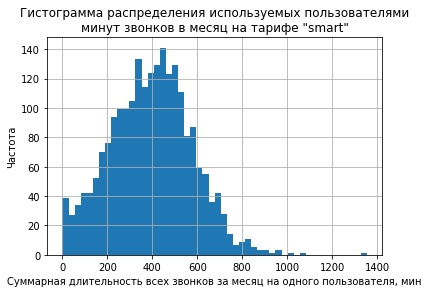

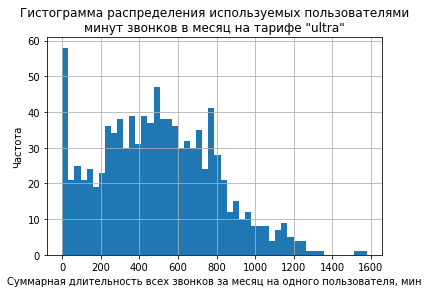

In [94]:
calls_users_smart.iloc[:, 12:24].stack().hist(bins=50)
plt.xlabel('Суммарная длительность всех звонков за месяц на одного пользователя, мин')
plt.ylabel('Частота')
plt.title('Гистограмма распределения используемых пользователями\nминут звонков в месяц на тарифе "smart"')
plt.show()
calls_users_ultra.iloc[:, 12:24].stack().hist(bins=50)
plt.xlabel('Суммарная длительность всех звонков за месяц на одного пользователя, мин')
plt.ylabel('Частота')
plt.title('Гистограмма распределения используемых пользователями\nминут звонков в месяц на тарифе "ultra"')
plt.show()

### Числовые значения распределений, представленных на гистограммах

In [95]:
calls_users_smart.iloc[:, 12:24].stack().agg(['min', 'max', 'mean','var','std','count'])

min          0.000000
max       1354.220000
mean       394.250152
var      32441.629949
std        180.115602
count     2230.000000
dtype: float64

In [96]:
calls_users_ultra.iloc[:, 12:24].stack().agg(['min', 'max', 'mean','var','std','count'])

min          0.000000
max       1578.060000
mean       496.564097
var      90101.773195
std        300.169574
count      986.000000
dtype: float64

In [97]:
temp_smart_calls=calls_users_smart.iloc[:, 12:24].reset_index().melt(id_vars=['user_id'])
print(temp_smart_calls[temp_smart_calls['value']>500]['user_id'].count(),'случая, когда', \
      temp_smart_calls[temp_smart_calls['value']>500]['user_id'].nunique(),'пользователя тарифа "smart" или',\
      round(temp_smart_calls[temp_smart_calls['value']>500]['user_id'].nunique()/temp_smart_calls['user_id'].nunique()*100),\
      '% подключившихся в 2018 году превышали 500 минут разговора в месяц, входящих в пакет.')

623 случая, когда 194 пользователя тарифа "smart" или 55 % подключившихся в 2018 году превышали 500 минут разговора в месяц, входящих в пакет.


In [98]:
temp_smart_calls_0=temp_smart_calls.groupby('user_id').sum().reset_index()
print(temp_smart_calls_0[temp_smart_calls_0['value']==0]['user_id'].count(),\
      'пользователя или', round(temp_smart_calls_0[temp_smart_calls_0['value']==0]['user_id'].count()/temp_smart_calls_0['user_id'].count()*100,2),\
      '% от всех подключившихся к тарифу "smart" вообще не пользовались звонками в 2018 году')

2 пользователя или 0.57 % от всех подключившихся к тарифу "smart" вообще не пользовались звонками в 2018 году


In [99]:
temp_ultra_calls_0=calls_users_ultra.iloc[:, 12:24].reset_index().melt(id_vars=['user_id']).groupby('user_id').sum().reset_index()
print(temp_ultra_calls_0[temp_ultra_calls_0['value']==0]['user_id'].count(),\
      'пользователя или', round(temp_ultra_calls_0[temp_ultra_calls_0['value']==0]['user_id'].count()/temp_ultra_calls_0['user_id'].count()*100,2),\
      '% от всех подключившихся к тарифу "ultra" вообще не пользовались звонками в 2018 году')

6 пользователя или 4.03 % от всех подключившихся к тарифу "ultra" вообще не пользовались звонками в 2018 году


### Построим графики средних значений, меняющиxся по месяцам, для тарифов "smart" и "ultra"

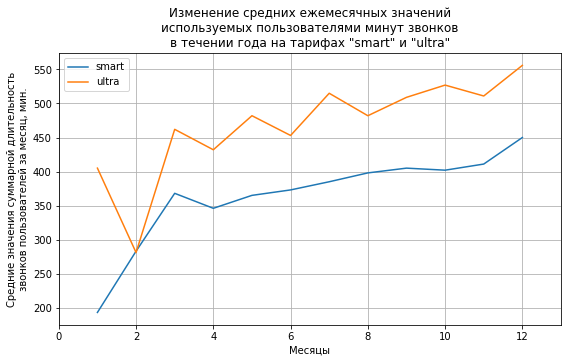

In [100]:
sum_table_calls.plot(x='months',y=['mean_minutes_smart','mean_minutes_ultra'],kind='line',grid = True, xlim=(0,13), figsize=(9,5),label=['smart','ultra'])
plt.ylabel('Средние значения суммарной длительность\nзвонков пользователей за месяц, мин.')
plt.xlabel('Месяцы')
plt.title('Изменение средних ежемесячных значений\nиспользуемых пользователями минут звонков\nв течении года на тарифах "smart" и "ultra"')
plt.show()

### На графиках видно, что
1. Средние значения звонков у обоих тарифов растут в течении года - это связано с тем, что выборка взята по пользователям подключившимся в 2018 году - далеко не все из них подключились в первый месяц года.
2. Пользователи тарифа "ultra" в среднем разговаривают по телефону дольше (около 500 мин/мес), чем пользователи тарифа "smart"(около 400 мин/мес) - это видно и на гистограммах распределения звонков на графиках выше.
3. Гистограмма распределения звонков для тарифа "smart" более узкая, чем для тарифа "ultra", что соответствует рассчитанному в таблице "sum_table_calls" стандартному отклонению - для тарифа "smart" оно меньше, чем для тарифа "ultra" - разброс затрачиваемых в месяц минут разговора у пользователей тарифа "ultra" больше, чем у тарифа  "smart". Это, видимо, связано с тем, что в тариф "ultra" включено 3000 минут разговора, а в тариф  "smart" только 500 минут, поэтому пользователи тарифа "ultra" ни в чем себе не отказывают, при этом в среднем тратят в разы меньше минут, чем у них есть в распоряжении, а пользователи тарифа  "smart" стараются не превышать имеющееся ограничение в 500 минут. В то же время для 55% пользователей тарифа "smart" имели место случаи превышения лимита звонков по тарифу в 500 минут.
4. Есть пользователи тарифов "ultra" и "smart", которые месяцами вообще не используют тариф для звонков - 6 и 2 человека соответственно - возможно, покупают для того, чтобы пользоваться мобильным интернетом.

### Построим гистограммы по количеству сообщений, которые ежемесячно отправляет каждый пользователь - для этого "вытянем" в один столбец данные таблиц "messages_users_smart" и "messages_users_ultra"

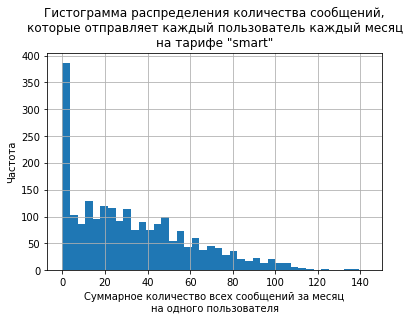

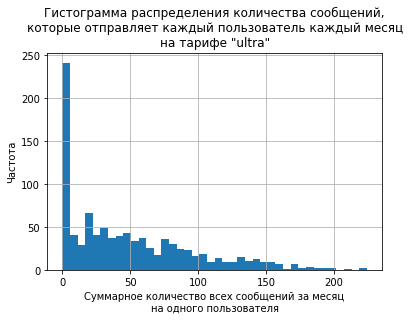

In [101]:
messages_users_smart.iloc[:, 0:12].stack().hist(bins=40)
plt.xlabel('Суммарное количество всех сообщений за месяц\nна одного пользователя')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества сообщений,\nкоторые отправляет каждый пользователь каждый месяц\nна тарифе "smart"')
plt.show()
messages_users_ultra.iloc[:, 0:12].stack().hist(bins=40)
plt.xlabel('Суммарное количество всех сообщений за месяц\nна одного пользователя')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества сообщений,\nкоторые отправляет каждый пользователь каждый месяц\nна тарифе "ultra"')
plt.show()

### Числовые значения распределений, представленных на гистограммах

In [102]:
messages_users_smart.iloc[:, 0:12].stack().agg(['min', 'max', 'mean','var','std','count'])

min         0.000000
max       143.000000
mean       33.369058
var       796.955256
std        28.230396
count    2230.000000
dtype: float64

In [103]:
messages_users_ultra.iloc[:, 0:12].stack().agg(['min', 'max', 'mean','var','std','count'])

min         0.000000
max       224.000000
mean       49.313387
var      2285.417425
std        47.806040
count     986.000000
dtype: float64

In [104]:
temp_smart_messages=messages_users_smart.iloc[:, 0:12].reset_index().melt(id_vars=['user_id'])
print(temp_smart_messages[temp_smart_messages['value']>50]['user_id'].count(),'случая, когда', \
      temp_smart_messages[temp_smart_messages['value']>50]['user_id'].nunique(),'пользователей тарифа "smart" или',\
      round(temp_smart_messages[temp_smart_messages['value']>50]['user_id'].nunique()/temp_smart_messages['user_id'].nunique()*100),\
      '% подключившихся в 2018 году превысили лимит в 50 смс в месяц, входящих в пакет.')

564 случая, когда 125 пользователей тарифа "smart" или 36 % подключившихся в 2018 году превысили лимит в 50 смс в месяц, входящих в пакет.


In [105]:
temp_smart_messages_0=temp_smart_messages.groupby('user_id').sum().reset_index()
print(temp_smart_messages_0[temp_smart_messages_0['value']==0]['user_id'].count(),\
      'пользователей или', round(temp_smart_messages_0[temp_smart_messages_0['value']==0]['user_id'].count()/temp_smart_messages_0['user_id'].count()*100),\
      '% от всех подключившихся к тарифу "smart" вообще не отправляли смс в 2018 году')

49 пользователей или 14 % от всех подключившихся к тарифу "smart" вообще не отправляли смс в 2018 году


In [106]:
temp_ultra_messages_0=messages_users_ultra.iloc[:, 0:12].reset_index().melt(id_vars=['user_id']).groupby('user_id').sum().reset_index()
print(temp_ultra_messages_0[temp_ultra_messages_0['value']==0]['user_id'].count(),\
      'пользователей или', round(temp_ultra_messages_0[temp_ultra_messages_0['value']==0]['user_id'].count()/temp_ultra_messages_0['user_id'].count()*100),\
      '% от всех подключившихся к тарифу "ultra" вообще не отправляли смс в 2018 году')

25 пользователей или 17 % от всех подключившихся к тарифу "ultra" вообще не отправляли смс в 2018 году


### Построим графики средних значений, меняющиxся по месяцам, для тарифов "smart" и "ultra"

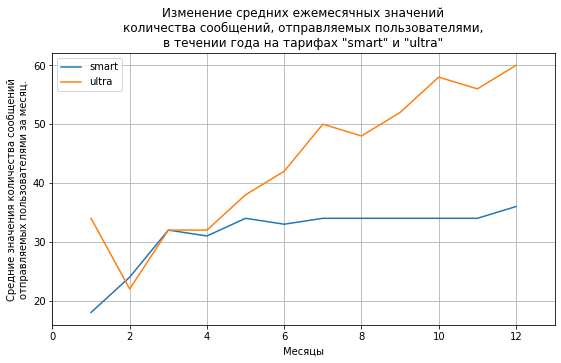

In [107]:
sum_table_messages.plot(x='months',y=['mean_messages_smart','mean_messages_ultra'],kind='line',grid = True, xlim=(0,13), figsize=(9,5),label=['smart','ultra'])
plt.ylabel('Средние значения количества сообщений\nотправляемых пользователями за месяц.')
plt.xlabel('Месяцы')
plt.title('Изменение средних ежемесячных значений\nколичества сообщений, отправляемых пользователями,\nв течении года на тарифах "smart" и "ultra"')
plt.show()

### На графиках видно, что
1. Отправка сообщений не пользуется большим спросом - как видно на гистограммах, есть пользователи, которые в течении месяцев не пользуются данной услугой. Из всех подключившихся в 2018 году услугой смс-рассылки вообще не пользовались 14 и 17% клиентов тарифов "smart" и "ultra" соответственно.
2. Средние значения числа сообщений у обоих тарифов растут в течении года - это связано с тем, что выборка взята по пользователям подключившимся в 2018 году - далеко не все из них подключились в первый месяц года.
3. Пользователи тарифа "ultra" в среднем отправляют больше сообщений (к концу года число сообщений стремится к 60 в месяц), чем пользователи тарифа "smart"(не превышает 40 сообщений в месяц). Это, видимо, связано с тем, что в тариф "ultra" включено 1000 сообщений, а в тариф  "smart" только 50 сообщений, поэтому пользователи тарифа "ultra" ни в чем себе не отказывают, при этом в среднем отправляют в разы меньше сообщений, чем у них есть в распоряжении, а пользователи тарифа  "smart" стараются не превышать имеющееся ограничение в 50 сообщений. В то же время для 36% пользователей тарифа "smart" имели место случаи превышения лимита смс по тарифу в 50 смс.

### Построим гистограммы по объему интернет-трафика, который ежемесячно тратит каждый пользователь - для этого "вытянем" в один столбец данные таблиц "internet_users_smart" и "internet_users_ultra"

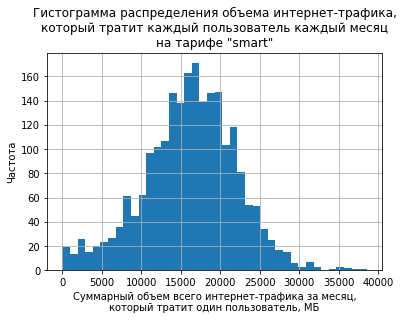

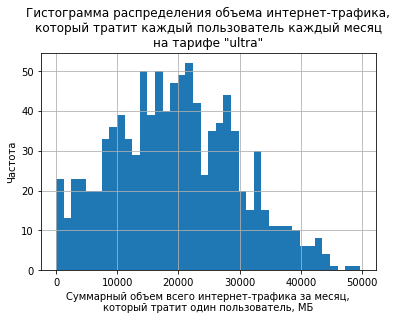

In [108]:
internet_users_smart.iloc[:, 0:12].stack().hist(bins=40)
plt.xlabel('Суммарный объем всего интернет-трафика за месяц,\nкоторый тратит один пользователь, МБ')
plt.ylabel('Частота')
plt.title('Гистограмма распределения объема интернет-трафика,\nкоторый тратит каждый пользователь каждый месяц\nна тарифе "smart"')
plt.show()
internet_users_ultra.iloc[:, 0:12].stack().hist(bins=40)
plt.xlabel('Суммарный объем всего интернет-трафика за месяц,\nкоторый тратит один пользователь, МБ')
plt.ylabel('Частота')
plt.title('Гистограмма распределения объема интернет-трафика,\nкоторый тратит каждый пользователь каждый месяц\nна тарифе "ultra"')
plt.show()

### Числовые значения распределений, представленных на гистограммах, ГБ

In [109]:
internet_users_smart.iloc[:, 0:12].stack().agg(['min', 'max', 'mean','var','std','count'])/1000

min          0.000000
max         38.552450
mean        16.201119
var      34564.843481
std          5.879187
count        2.230000
dtype: float64

In [110]:
internet_users_ultra.iloc[:, 0:12].stack().agg(['min', 'max', 'mean','var','std','count'])/1000

min           0.000000
max          49.745690
mean         19.449060
var      102032.129465
std          10.101095
count         0.986000
dtype: float64

In [111]:
temp_smart_internet=internet_users_smart.iloc[:, 0:12].reset_index().melt(id_vars=['user_id'])
print(temp_smart_internet[temp_smart_internet['value']>15000]['user_id'].count(),'случая, когда', \
      temp_smart_internet[temp_smart_internet['value']>15000]['user_id'].nunique(),'пользователей тарифа "smart" или',\
      round(temp_smart_internet[temp_smart_internet['value']>15000]['user_id'].nunique()/temp_smart_internet['user_id'].nunique()*100),\
      '% подключившихся в 2018 году превысили лимит в 15 ГБ в месяц, входящих в пакет.')

1347 случая, когда 314 пользователей тарифа "smart" или 89 % подключившихся в 2018 году превысили лимит в 15 ГБ в месяц, входящих в пакет.


In [112]:
temp_ultra_internet=internet_users_ultra.iloc[:, 0:12].reset_index().melt(id_vars=['user_id'])
print(temp_ultra_internet[temp_ultra_internet['value']>30000]['user_id'].count(),'случая, когда', \
      temp_ultra_internet[temp_ultra_internet['value']>30000]['user_id'].nunique(),'пользователей тарифа "ultra" или',\
      round(temp_ultra_internet[temp_ultra_internet['value']>30000]['user_id'].nunique()/temp_ultra_internet['user_id'].nunique()*100),\
      '% подключившихся в 2018 году превысили лимит в 30 ГБ в месяц, входящих в пакет.')

148 случая, когда 46 пользователей тарифа "ultra" или 31 % подключившихся в 2018 году превысили лимит в 30 ГБ в месяц, входящих в пакет.


### Построим графики средних значений, меняющиxся по месяцам, для тарифов "smart" и "ultra"

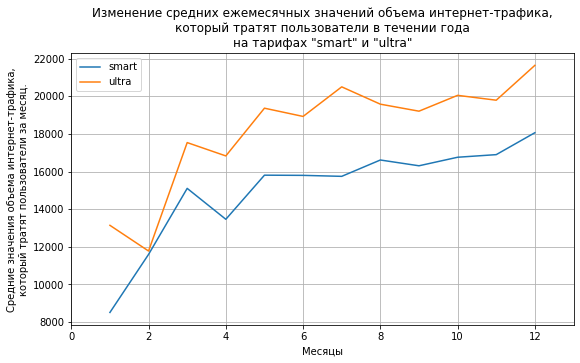

In [113]:
sum_table_internet.plot(x='months',y=['mean_internet_smart','mean_internet_ultra'],kind='line',grid = True, xlim=(0,13), figsize=(9,5),label=['smart','ultra'])
plt.ylabel('Средние значения объема интернет-трафика,\nкоторый тратят пользователи за месяц.')
plt.xlabel('Месяцы')
plt.title('Изменение средних ежемесячных значений объема интернет-трафика,\nкоторый тратят пользователи в течении года\nна тарифах "smart" и "ultra"')
plt.show()

### На графиках видно, что
1. Средние значения объема интернет-трафика у обоих тарифов растут в течении года - это связано с тем, что выборка взята по пользователям подключившимся в 2018 году - далеко не все из них подключились в первый месяц года.
2. Пользователи тарифа "ultra" в среднем тратят больше интернета (около 19 ГБ), чем пользователи тарифа "smart"(около 16 ГБ) - это видно и на гистограммах распределения объемов интернет-трафика. Очевидно, это связано с объемом интернета, входящим в тариф - 15 ГБ в тарифе "smart" и 30 гБ в тарифе "ultra"
3. На обоих тарифах части пользователям не хватает включенного в тариф объема интернет-трафика, и они доплачивают за дополнительный. На тарифе "smart" почти все пользователи сталкивались с ситуацией нехватки интернет-трафика в рамках лимита в 15 ГБ(89%), а на тарифе "ultra" у 31% пользователей имели место случаи превышения лимита по интернет-трафику.

## Выводы
1.  Были рассчитаны среднее количество, дисперсия и стандартное отклонение для минут разговора, числа сообщений и  объёма интернет-трафика по месяцам для тарифов "smart" и "ultra"
2. Средние значения длительности звонков, количества сообщений и объема интернет-трафика у обоих тарифов растут в течении года - это связано с тем, что выборка взята по пользователям, подключившимся в 2018 году - далеко не все из них подключились в первый месяц года.
3. Пользователи тарифа "ultra" в среднем разговаривают по телефону дольше (около 500 мин/мес против 400 мин/мес), отправляют больше сообщений (49 смс/мес против 33 смс/мес) и используют больший объем интернет-трафика (19 ГБ против 16 ГБ), чем пользователи тарифа "smart", при этом в случае звонков и смс лимит по тарифу оказывается сильно больше, чем требуется клиентам - в 2018 году максимальная месячная суммарная длительность звонков была 1578 мин, а максимальное число отправленных в месяц смс 224. Очевидно, что это связано с тем, что лимиты по тарифу "ultra" заметно больше, чем по тарифу "smart": 3000 минут разговора против 500, 1000 смс против 50 и 30 ГБ интернет-трафика против 50 ГБ. 
4. На обоих тарифах есть пользователи, которые месяцами вообще не используют тариф для звонков ("smart" - 0,6%, "ultra" - 4%) или рассылки смс ("smart" - 14%, "ultra" - 17%) - возможно, покупают для того, чтобы пользоваться только мобильным интернетом.
5. На обоих тарифах части пользователям не хватает включенного в тариф объема интернет-трафика, и они доплачивают за дополнительный, однако на тарифе "smart" такая нехватка интернета имеет место в случае большего числа пользователей - 89% против 31% пользователей тарифа "ultra".
6. Пользователи тарифа "ultra", хотя и пользуются услугами связи с бОльшим размахом, чем пользователи тарифа "smart", однако в среднем они используют объемы, входящих туда услуг, меньше, чем на 65% по интернет-трафику (19ГБ/30ГБ=0,63), на 17% по звонкам(500 мин/3000 мин = 0,17) и на 5% по смс (49/1000=0,05).
7. Для 55% пользователей тарифа "smart" имели место случаи превышения лимита звонков по тарифу в 500 минут, для 36% - превышения лимита смс по тарифу в 50 смс, для 89% - нехватки интернет-трафика в рамках лимита в 15 ГБ.
8. В феврале (месяц №2) на тарифе "ultra" был заметный спад в количестве звонков, сообщений и используемого интернет-трафика - возможно, в этом месяце случилась какая-нибудь техническая неполадка со связью, коснувшаяся пользователей данного тарифа.

## Шаг 4. Проверка гипотез<a id="step4"></a> 

###  Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Соответственно 

    1. Н0: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается (равна)
    2. Н1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается (не равна)

### Разобъем таблицу "every_month_profit" на две по видам тарифа.

In [114]:
profit_smart=every_month_profit.merge(smart_users, on='user_id', how='inner').set_index('user_id')
profit_smart.head(3)

,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1163.87,550.00,11,12
1002,NaN,NaN,NaN,NaN,NaN,550.00,994.02,1541.85,816.22,550.00,1195.46,1100.75,6,12
1005,550.0,550.0,788.62,1060.6,746.86,782.71,677.29,852.37,556.00,1104.67,623.02,740.29,1,12


In [115]:
profit_ultra=every_month_profit.merge(ultra_users, on='user_id', how='inner').set_index('user_id')
profit_ultra.head(3)

,"(sum, 1)","(sum, 2)","(sum, 3)","(sum, 4)","(sum, 5)","(sum, 6)","(sum, 7)","(sum, 8)","(sum, 9)","(sum, 10)","(sum, 11)","(sum, 12)",reg_month,churn_month
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,5,12
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,8,12
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,5,12


### "Вытянем" в один столбец данные таблиц "profit_smart" и "profit_ultra", чтоб создать выборки по всем месячным выручкам со всех клиентов тарифов

In [116]:
array_smart=profit_smart.iloc[:, 0:12].stack()
array_smart.shape

(2230,)

In [117]:
array_ultra=profit_ultra.iloc[:, 0:12].stack()
array_ultra.shape

(986,)

### Визуализируем распределение каждой выборки с помощью гистограмм и точечных диаграмм.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


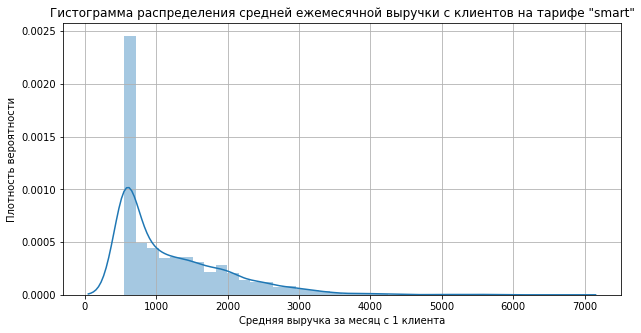

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


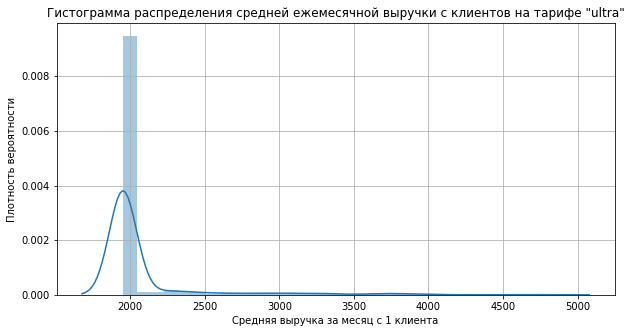

In [118]:
plt.figure(figsize=(10,5))
sns.distplot(array_smart.tolist())
plt.xlabel('Средняя выручка за месяц с 1 клиента')
plt.ylabel('Плотность вероятности')
plt.title('Гистограмма распределения средней ежемесячной выручки с клиентов на тарифе "smart"')
plt.grid()
plt.show()
plt.figure(figsize=(10,5))
sns.distplot(array_ultra.tolist())
plt.xlabel('Средняя выручка за месяц с 1 клиента')
plt.ylabel('Плотность вероятности')
plt.title('Гистограмма распределения средней ежемесячной выручки с клиентов на тарифе "ultra"')
plt.grid()
plt.show()

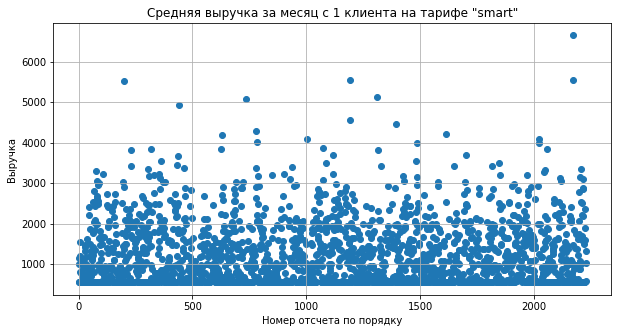

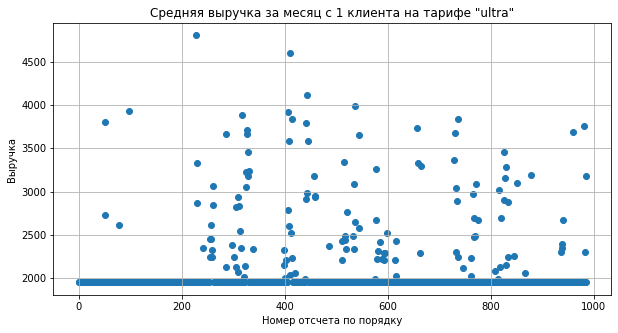

In [119]:
x_values = pd.Series(range(0,len(array_smart)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, array_smart) 
plt.ylabel('Выручка')
plt.xlabel('Номер отсчета по порядку')
plt.title('Средняя выручка за месяц с 1 клиента на тарифе "smart"')
plt.grid()
plt.show()
x_values = pd.Series(range(0,len(array_ultra)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, array_ultra) 
plt.ylabel('Выручка')
plt.xlabel('Номер отсчета по порядку')
plt.title('Средняя выручка за месяц с 1 клиента на тарифе "ultra"')
plt.grid()
plt.show()

### Как видно на графиках, большинство пользователей тарифа "ultra" наибольшее количество месяцев вписывается в стоимость тарифа и не платит больше 1950 руб/месяц. Что касается тарифа "smart", то среди его пользователей число людей, вынужденных помимо стоимости тарифа в 550 руб доплачивать за превышение лимитов, больше. 
### Интересно также, что отдельные клиенты в отдельные месяцы приносили выручки больше на дешевом тарифе "smart"(более 5000 руб/мес), чем какие-либо клиенты на дорогом тарифе "ultra".
### Гистограммы распределения выборок имеют вид, не соответствующий нормальному распределению, поэтому невозможно использовать параметрические критерии при оценке выборок.

### О том, что выборки не распределены нормально, говорит и проверка их с помощью критерия Шапиро-Уилка

In [120]:
alpha = 0.05  
print('Проверка на нормальность распределения средней ежемесячной выручки с клиентов на тарифе "smart":')
results = st.shapiro(array_smart)
p_value = results[1]  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
print()    
print('Проверка на нормальность распределения средней ежемесячной выручки с клиентов на тарифе "ultra":')
results = st.shapiro(array_ultra)
p_value = results[1]  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

Проверка на нормальность распределения средней ежемесячной выручки с клиентов на тарифе "smart":
p-значение:  7.006492321624085e-45
Отвергаем нулевую гипотезу: распределение не нормально

Проверка на нормальность распределения средней ежемесячной выручки с клиентов на тарифе "ultra":
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


### Для проверки гипотез используем непараметрический U-критерий Манна-Уитни.
### Зададим уровень значимости в стандартные 5% 

In [121]:
alpha = 0.05  
results = st.mannwhitneyu(array_smart,array_ultra)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  4.168309405361863e-222
Отвергаем нулевую гипотезу: разница статистически значима


### Вероятность случайно получить разные значения средних для данных выборок минимальна 4*10^(-222) - следовательно, мы отвергаем нулевую гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается (равна)

### Определим среднее и медиану, а также их доверительные интервалы для рассматриваемых выборок. Доверительные интервалы найдем с помощью метода bootstrap.

In [122]:
print('Среднее значение выручки, тариф "smart":',array_smart.mean().round(1))
data=(array_smart,)
bootstrap_smart_mean = bootstrap(data, np.mean, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для среднего, тариф "smart":','[',bootstrap_smart_mean.confidence_interval.low.round(1),\
      ',',bootstrap_smart_mean.confidence_interval.high.round(1),']')

Среднее значение выручки, тариф "smart": 1210.2
Доверительный интервал для среднего, тариф "smart": [ 1178.4 , 1243.1 ]


In [123]:
print('Среднее значение выручки, тариф "ultra":',array_ultra.mean().round(1))
data=(array_ultra,)
bootstrap_ultra_mean = bootstrap(data, np.mean, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для среднего, тариф "ultra":','[',bootstrap_ultra_mean.confidence_interval.low.round(1),\
      ',',bootstrap_ultra_mean.confidence_interval.high.round(1),']')

Среднее значение выручки, тариф "ultra": 2062.4
Доверительный интервал для среднего, тариф "ultra": [ 2040.5 , 2086.3 ]


In [124]:
print('Медианное значение выручки, тариф "smart":',array_smart.median().round(1))
data=(array_smart,)
bootstrap_smart_median = bootstrap(data, np.median, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для медианы, тариф "smart":','[',bootstrap_smart_median.confidence_interval.low.round(1),\
      ',',bootstrap_smart_median.confidence_interval.high.round(1),']')

Медианное значение выручки, тариф "smart": 932.8
Доверительный интервал для медианы, тариф "smart": [ 885.9 , 968.0 ]


In [125]:
print('Медианное значение выручки, тариф "ultra":',array_ultra.median().round(1))
data=(array_ultra,)
bootstrap_ultra_median = bootstrap(data, np.median, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для медианы, тариф "ultra":','[',bootstrap_ultra_median.confidence_interval.low.round(1),\
      ',',bootstrap_ultra_median.confidence_interval.high.round(1),']')

Медианное значение выручки, тариф "ultra": 1950.0
Доверительный интервал для медианы, тариф "ultra": [ 1950.0 , 1950.0 ]


### В результате проверки гипотезы нам пришлось отвергнуть гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается. Если судить по рассчитанным средним значениям, доверительные интервалы которых не пересекаются, выручка от тарифа «Ультра» оказывается почти в 2 раза больше, чем от тарифа «Смарт» , следовательно, тариф  «Ультра» приносит больше денег.

###  Проверим гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Соответственно 

    1. Н0: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов
    2. Н1: средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов

### Создадим две вспомогательные таблицы для пользователей из Москвы и из других городов.

In [126]:
Moscow_users=users[users['city']=='Москва']['user_id']
other_cities_users=users[users['city']!='Москва']['user_id']

### Разобъем таблицу "every_month_profit" на две по городам: пользователи из Москвы и из других городов.

In [127]:
profit_Moscow=every_month_profit.merge(Moscow_users, on='user_id', how='inner').set_index('user_id')
profit_Moscow.shape

(99, 14)

In [128]:
profit_other_cities=every_month_profit.merge(other_cities_users, on='user_id', how='inner').set_index('user_id')
profit_other_cities.shape

(401, 14)

### "Вытянем" в один столбец данные таблиц "profit_Moscow" и "profit_other_cities", чтоб создать выборки по всем месячным выручкам со всех клиентов 

In [129]:
array_Moscow=profit_Moscow.iloc[:, 0:12].stack()
array_Moscow.shape

(611,)

In [130]:
array_other_cities=profit_other_cities.iloc[:, 0:12].stack()
array_other_cities.shape

(2605,)

### Визуализируем распределение каждой выборки с помощью гистограмм и точечных диаграмм.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


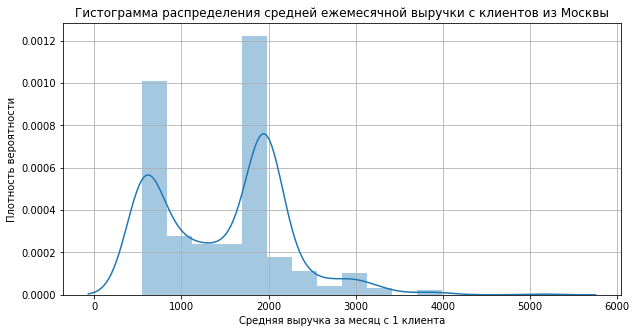

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


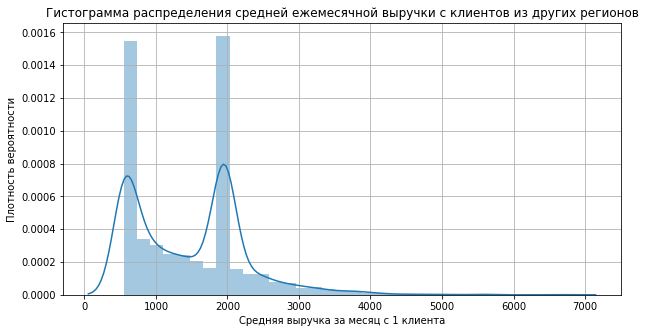

In [131]:
plt.figure(figsize=(10,5))
sns.distplot(array_Moscow.tolist())
plt.xlabel('Средняя выручка за месяц с 1 клиента')
plt.ylabel('Плотность вероятности')
plt.title('Гистограмма распределения средней ежемесячной выручки с клиентов из Москвы')
plt.grid()
plt.show()
plt.figure(figsize=(10,5))
sns.distplot(array_other_cities.tolist())
plt.xlabel('Средняя выручка за месяц с 1 клиента')
plt.ylabel('Плотность вероятности')
plt.title('Гистограмма распределения средней ежемесячной выручки с клиентов из других регионов')
plt.grid()
plt.show()

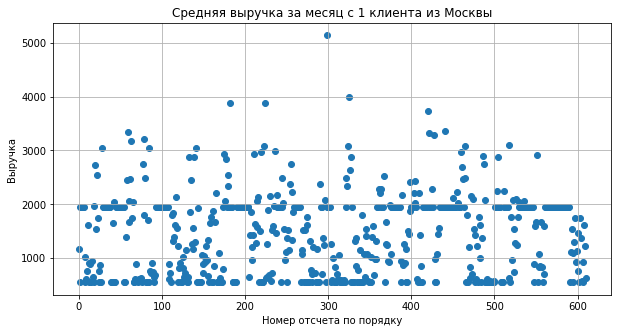

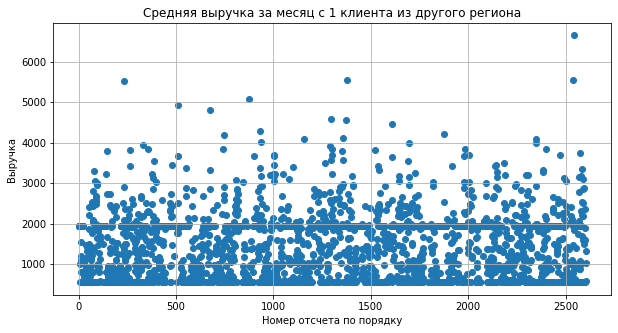

In [132]:
x_values = pd.Series(range(0,len(array_Moscow)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, array_Moscow) 
plt.ylabel('Выручка')
plt.xlabel('Номер отсчета по порядку')
plt.title('Средняя выручка за месяц с 1 клиента из Москвы')
plt.grid()
plt.show()
x_values = pd.Series(range(0,len(array_other_cities)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, array_other_cities) 
plt.ylabel('Выручка')
plt.xlabel('Номер отсчета по порядку')
plt.title('Средняя выручка за месяц с 1 клиента из другого региона')
plt.grid()
plt.show()

### Гистограммы распределения выборок имеют вид, не соответствующий нормальному распределению, поэтому невозможно использовать параметрические критерии при оценке выборок.

### О том, что выборки не распределены нормально, говорит и проверка их с помощью критерия Шапиро-Уилка

In [133]:
alpha = 0.05  
print('Проверка на нормальность распределения средней ежемесячной выручки с клиентов из Москвы:')
results = st.shapiro(array_Moscow)
p_value = results[1]  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
print()    
print('Проверка на нормальность распределения средней ежемесячной выручки с клиентов из других регионов:')
results = st.shapiro(array_other_cities)
p_value = results[1]  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

Проверка на нормальность распределения средней ежемесячной выручки с клиентов из Москвы:
p-значение:  2.0975532882020303e-20
Отвергаем нулевую гипотезу: распределение не нормально

Проверка на нормальность распределения средней ежемесячной выручки с клиентов из других регионов:
p-значение:  1.200114043801703e-40
Отвергаем нулевую гипотезу: распределение не нормально


### Для проверки гипотез используем непараметрический U-критерий Манна-Уитни.
### Зададим уровень значимости в стандартные 5% 

In [134]:
alpha = 0.05  
results = st.mannwhitneyu(array_Moscow, array_other_cities)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.2562275732990378
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


### Вероятность случайно получить разные значения средних для данных выборок почти 26% (>5%) - следовательно, мы не можем отвергнуть нулевую гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

### Определим среднее и медиану, а также их доверительные интервалы для рассматриваемых выборок. Доверительные интервалы найдем с помощью метода bootstrap.

In [135]:
print('Среднее значение выручки, Москва:',array_Moscow.mean().round(1))
data=(array_Moscow,)
bootstrap_Moscow_mean = bootstrap(data, np.mean, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для среднего, Москва:','[',bootstrap_Moscow_mean.confidence_interval.low.round(1),\
      ',',bootstrap_Moscow_mean.confidence_interval.high.round(1),']')

Среднее значение выручки, Москва: 1493.7
Доверительный интервал для среднего, Москва: [ 1435.5 , 1552.7 ]


In [136]:
print('Среднее значение выручки, другие регионы:',array_other_cities.mean().round(1))
data=(array_other_cities,)
bootstrap_other_cities_mean = bootstrap(data, np.mean, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для среднего, другие регионы:','[',bootstrap_other_cities_mean.confidence_interval.low.round(1),\
      ',',bootstrap_other_cities_mean.confidence_interval.high.round(1),']')

Среднее значение выручки, другие регионы: 1466.3
Доверительный интервал для среднего, другие регионы: [ 1435.8 , 1496.3 ]


In [137]:
print('Медианное значение выручки, Москва:',array_Moscow.median().round(1))
data=(array_Moscow,)
bootstrap_Moscow_median = bootstrap(data, np.median, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для медианы, Москва:','[',bootstrap_Moscow_median.confidence_interval.low.round(1),\
      ',',bootstrap_Moscow_median.confidence_interval.high.round(1),']')

Медианное значение выручки, Москва: 1662.8
Доверительный интервал для медианы, Москва: [ 1528.9 , 1881.2 ]


In [138]:
print('Медианное значение выручки, другие регионы:',array_other_cities.median().round(1))
data=(array_other_cities,)
bootstrap_other_cities_median = bootstrap(data, np.median, confidence_level=0.95, random_state=1, method='percentile')
print('Доверительный интервал для медианы, другие регионы:','[',bootstrap_other_cities_median.confidence_interval.low.round(1),\
      ',',bootstrap_other_cities_median.confidence_interval.high.round(1),']')

Медианное значение выручки, другие регионы: 1488.3
Доверительный интервал для медианы, другие регионы: [ 1407.1 , 1591.1 ]


### В результате проверки гипотезы мы не смогли отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Рассчитанные средние значения, доверительные интервалы которых имеют пересечения, подтверждают этот вывод.

## Выводы
1. В результате проверки гипотезы о средней выручке пользователей тарифов «Ультра» и «Смарт», проведенной с помощью U-критерия Манна-Уитни, была отвергнута нулевая гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается (равна). Если судить по рассчитанным средним значениям выручка от тарифа «Ультра» оказывается почти в 2 раза больше, чем от тарифа «Смарт» , таким образом с большой вероятностью, тариф  «Ультра» приносит больше денег.
2. В результате проверки гипотезы о средней выручке пользователей из Москвы и из других регионов, проведенной с помощью U-критерия Манна-Уитни, не удалось отвергнуть нулевую гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

## Шаг 5. Общий вывод<a id="step5"></a> 
1. Для анализа было представлено 5 таблиц с данными по пользователям двух тарифов "smart" и "ultra":
    1. "calls" - информация о дате и длительности звонков, совершенных пользователями
    2. "internet" - данные о датах выхода в интернет и объеме использованного пользователями интернет-трафика
    3. "messages" - информация об отправленных пользователями сообщениях
    4. "tariffs" - условия тарифов "smart" и "ultra" 
    5. "users" - информация о пользователях тарифов
2. В исходных таблицах хранится информация о действиях пользователей с 1 января по 31 декабря 2018 года - всего за 365 дней.
3. Хотя в базе данных (таблице "users") содержится информация о 500 различных пользователях, не все пользователи пользуются одновременно всеми услугами:
    1. данные по звонкам есть только для 492 пользователей
    2. данные по смс есть только для 426 пользователей
    3. данные по использованию интернета есть только для 497 пользователей
4. В процессе подготовки данных был преобразован тип данных из object в datetime64 в столбцах таблиц:
    1. 'call_date' в таблице "calls"
    2. 'session_date' в таблице "internet"
    3. 'message_date' в таблице "messages"
    4.  "churn_date" и "reg_date" в таблице "users"
5. В данных не было обнаружено очевидных ошибок, требующих корректировки
6. В ходе выполнения проекта были сформированы таблицы со следующими данными для каждого пользователя:
    1. Количество сделанных звонков и израсходованных минут разговора по месяцам ("calls_users_stat");
    2. Количество отправленных сообщений по месяцам ("messages_users_stat");
    3. Объем израсходованного интернет-трафика по месяцам ("internet_users_stat");
    4. Помесячная выручка с каждого пользователя ("every_month_profit").
7.  Были рассчитаны среднее количество, дисперсия и стандартное отклонение для минут разговора, числа сообщений и  объёма интернет-трафика по месяцам для тарифов "smart" и "ultra", построены гистограммы распределения ежемесячных затрат пользователей по данным показателям. Анализ графиков позволил сделать следующие выводы:
    1. Средние значения длительности звонков, количества сообщений и объема интернет-трафика у обоих тарифов растут в течении года - это связано с тем, что выборка взята по пользователям, подключившимся в 2018 году - далеко не все из них подключились в первый месяц года.
    2. Пользователи тарифа "ultra" в среднем разговаривают по телефону дольше (около 500 мин/мес против 400 мин/мес), отправляют больше сообщений (49 смс/мес против 33 смс/мес) и используют больший объем интернет-трафика (19 ГБ против 16 ГБ), чем пользователи тарифа "smart", при этом в случае звонков и смс лимит по тарифу оказывается сильно больше, чем требуется клиентам - в 2018 году максимальная месячная суммарная длительность звонков была 1578 мин, а максимальное число отправленных в месяц смс 224. Очевидно, что это связано с тем, что лимиты по тарифу "ultra" заметно больше, чем по тарифу "smart": 3000 минут разговора против 500, 1000 смс против 50 и 30 ГБ интернет-трафика против 50 ГБ. 
    3. На обоих тарифах есть пользователи, которые месяцами вообще не используют тариф для звонков ("smart" - 0,6%, "ultra" - 4%) или рассылки смс ("smart" - 14%, "ultra" - 17%) - возможно, покупают для того, чтобы пользоваться только мобильным интернетом.
    4. На обоих тарифах части пользователям не хватает включенного в тариф объема интернет-трафика, и они доплачивают за дополнительный, однако на тарифе "smart" такая нехватка интернета имеет место в случае большего числа пользователей - 89% против 31% пользователей тарифа "ultra".
    5. Пользователи тарифа "ultra", хотя и пользуются услугами связи с бОльшим размахом, чем пользователи тарифа "smart", однако в среднем они используют объемы, входящих туда услуг, меньше, чем на 65% по интернет-трафику (19ГБ/30ГБ=0,63), на 17% по звонкам(500 мин/3000 мин = 0,17) и на 5% по смс (49/1000=0,05).
    6. Для 55% пользователей тарифа "smart" имели место случаи превышения лимита звонков по тарифу в 500 минут, для 36% - превышения лимита смс по тарифу в 50 смс, для 89% - нехватки интернет-трафика в рамках лимита в 15 ГБ.
    7. В феврале (месяц №2) на тарифе "ultra" был заметный спад в количестве звонков, сообщений и используемого интернет-трафика - возможно, в этом месяце случилась какая-нибудь техническая неполадка со связью, коснувшаяся пользователей данного тарифа.       
8. Была проверена гипотеза о средней выручке пользователей тарифов «Ультра» и «Смарт» - в результате нулевая гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается (равна) была отвергнута. Если судить по рассчитанным средним значениям выручка от тарифа «Ультра» оказывается почти в 2 раза больше, чем от тарифа «Смарт» , таким образом с большой вероятностью, тариф  «Ультра» приносит больше денег.
9. Была проверена гипотеза о средней выручке пользователей из Москвы и из других регионов - в результате не удалось отвергнуть нулевую гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
10. Исходя из приведенного выше анализа можно рекомендовать коммерческому департаменту скорректировать рекламный бюджет в сторону тарифа «Ультра», т.к. он приносит больше денег компании и может в большей степени удовлетворить нужды пользователей тарифа «Смарт», выходящих за лимиты пакета.